Topic: clustering

In [2]:
import sklearn
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math

In [3]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [16]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

# T90 vs flux

In [4]:
time = data[names=='T90'][data[names=='T90']!='-999']
flux = data[names=='fluence'][data[names=='T90']!='-999']
time = np.float64(time[flux!='-999'])
flux = np.float64(flux[flux!='-999'])

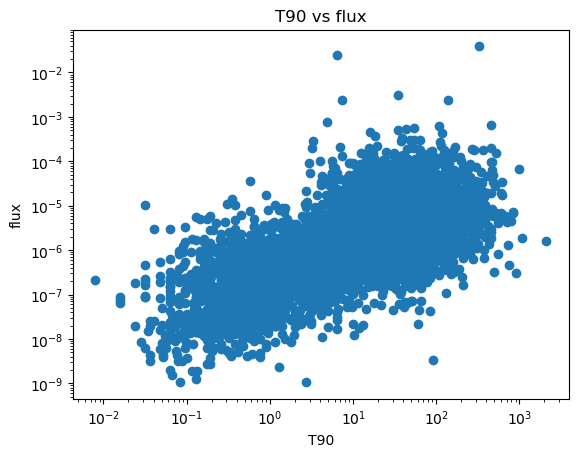

In [5]:
plt.scatter(time,flux)
plt.title('T90 vs flux')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T90')
plt.ylabel('flux')
plt.show()

Looks like there are two "blobs". Let's use K-means to group the dataset in two clusters.

In [7]:
X = np.vstack((np.log10(time[(time!=0) & (flux!=0)]),np.log10(flux[(time!=0) & (flux!=0)]))).T

## K-Means

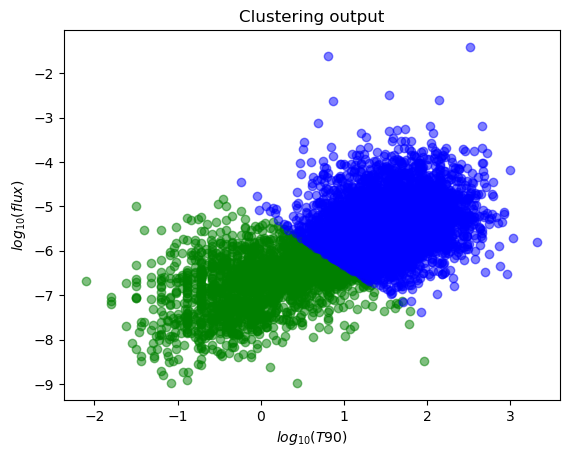

In [9]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['g','b','r','k','y']
for ii in range(n_clusters):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                c=colors[ii],alpha=0.5)

plt.xlabel(r"$log_{10}(T90)$")
plt.ylabel(r"$log_{10}(flux)$")
plt.title('Clustering output');

## Mean-shift

In [19]:
scaler = preprocessing.StandardScaler()
bandwidth = 1.5
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=1.5, bin_seeding=True, cluster_all=False)

[-1  0  1]
number of estimated clusters : 2


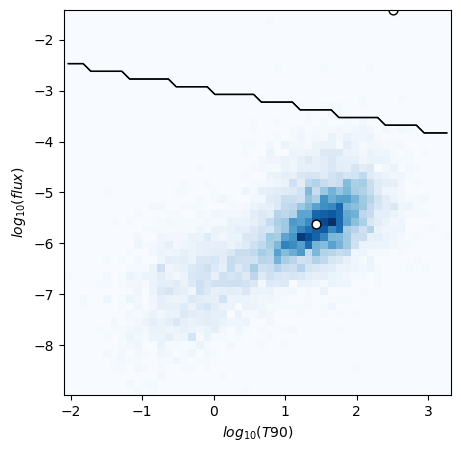

In [20]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
b = 50
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], b)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, b * b)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((b, b))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((b, b))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$log_{10}(T90)$")
ax.set_ylabel(r"$log_{10}(flux)$")

plt.show()


Mean-shift clustering is sensible to outliers: in our case, it identifies two clusters, but it looks like one of them consists of a few points that are far away from the rest of the dataset.

# T90 distribution

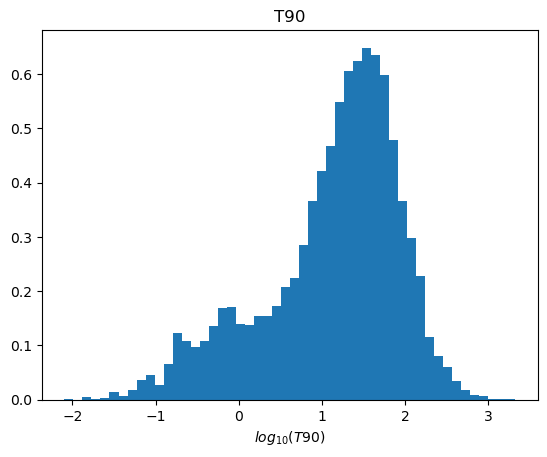

In [12]:
time = np.log10(np.float64(data[names=='T90'][data[names=='T90']!='-999']))
a,b,c = plt.hist(time,50,density=True)
plt.xlabel(r"$log_{10}(T90)$")
plt.title('T90')
plt.show()

Looks like there are two modes. Let's use a gaussian mixture model to separate them.

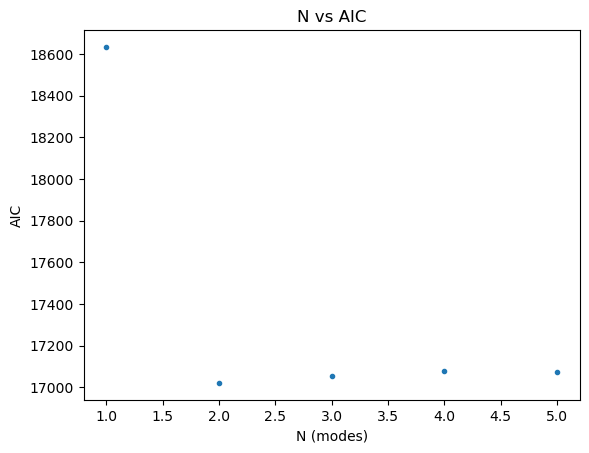

Minimum value for AIC: N = 2


In [13]:
aic = []
time_gm = np.array(time[:,np.newaxis])
N = np.linspace(1,5,5,dtype=int)
for i in N:
    gm = GaussianMixture(n_components=i).fit(time_gm)
    aic.append(gm.aic(time_gm))
plt.plot(N,aic,'.')
plt.title('N vs AIC')
plt.xlabel('N (modes)')
plt.ylabel('AIC')
plt.show()
print('Minimum value for AIC: N =', N[np.array(aic)==np.min(np.array(aic))][0])

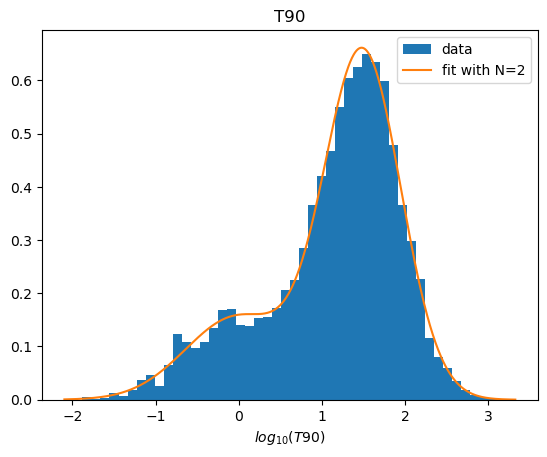

In [14]:
#compare the best fit with the initial data
a,b,c=plt.hist(time_gm,50,density=True,label='data')
gm = GaussianMixture(n_components=N[np.array(aic)==np.min(np.array(aic))][0]).fit(time_gm)
x_plot = np.linspace(np.min(time_gm),np.max(time_gm),1000)
plt.plot(x_plot,np.exp(gm.score_samples(x_plot[:,np.newaxis])),label='fit with N=2')
plt.xlabel(r"$log_{10}(T90)$")
plt.title('T90')
plt.legend()
plt.show()

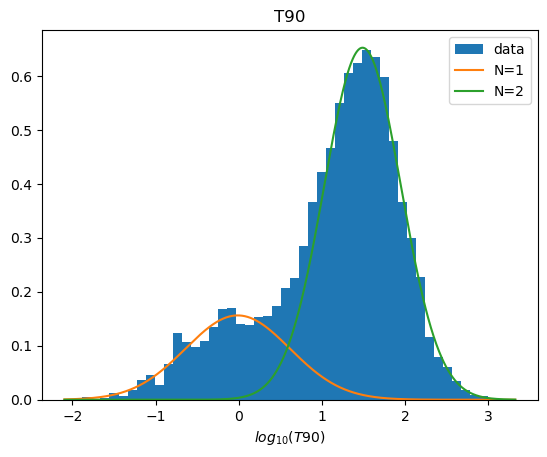

In [15]:
a,b,c=plt.hist(time_gm,50,density=True,label='data')
a = gm.predict_proba(x_plot[:,np.newaxis])
plt.plot(x_plot,a[:,0]*np.exp(gm.score_samples(x_plot[:,np.newaxis])),label='N=1')
plt.plot(x_plot,a[:,1]*np.exp(gm.score_samples(x_plot[:,np.newaxis])),label='N=2')
plt.legend()
plt.xlabel(r"$log_{10}(T90)$")
plt.title('T90')
plt.show()